In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Verificación de una persona y seguimiento mediante un jetbot
Con este notebook buscamos que el robot jetbot, sea capaz de reconocer a una persona en una habitación. En cuanto la encuentra, para. Para ello se basa en lo siguiente:
1. Se usa un modelo de detección de caras (https://github.com/timesler/facenet-pytorch). Se extrae la más cercana
2. Se usa un modelo de verificación de caras respecto a una foto base ( se usa el modelo de redes siamesas de verificación usado anteriormente)
3. Se usa un modelo de detección de obstáculos, para que en caso de encontrar uno, el robot rote.
4.  Se programa el robot, para que dependiendo de estos resultados de estos modelos haga lo siguiente:
    a) Si encuentra un obstáculo, gira a la izquierda
    b) Si no lo encuentra, busca caras en el frame de la cámara. Si no encuentra caras, sigue hacia adelante.
    c) Si encuentra caras, busca que sea igual a la foto base predefinida. Primero se hace un crop de la zona con la cara y se evalúa con la red siamesa. En caso de que sea igual para, sino sigue hacia adelante.


**OJO! ESTE NOTEBOOK NO FUNCIONA CON EL CONDA.YML actual, tiene unas librerías especificas de jetbot y no es reproducible desde un entorno fuera de jetbot**


A continuación, primero se prueban estos modelos por separado para ver que funcionan correctamente antes de implementarlos al jetbot. Posteriormente, se implementa dentro del robot

# Prueba del modelo de verificación de caras

Importamos las librerías del modelo de verificación de caras, que a la hora de cargar el modelo de verificación de caras que hemos creado con redes siamesas, son necesarias para su correcta ejecución.

In [2]:
import sys
sys.path.append("/workspace/jetbot/workspace/face-verification/research/scripts/lib")

In [3]:
from models.predicts import predict_model
from visualization.camera import predictOverVideoSim

Cargamos primero el modelo de detección de caras

In [4]:
#from jetbot import ObjectDetector
#model = ObjectDetector('ssd_mobilenet_v2_coco.engine')
from facenet_pytorch import MTCNN
import torch
import torch
import cv2
from PIL import Image, ImageDraw
from jetbot import Camera
import mlflow
from jetbot import Robot

In [5]:
from IPython.display import display
import ipywidgets.widgets as widgets


In [6]:
#model = InceptionResnetV1(pretrained='vggface2').eval().cuda()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(keep_all=True, device=device)


Cargamos la cámara, para sacar a posteriori fotos y videos.

> Internally, the Camera class uses GStreamer to take advantage of Jetson Nano's Image Signal Processor (ISP).  This is super fast and offloads
> a lot of the resizing computation from the CPU. 

In [6]:
camera = Camera.instance(width=300, height=300)

Extraemos un frame de la cámara y vemos el mismo

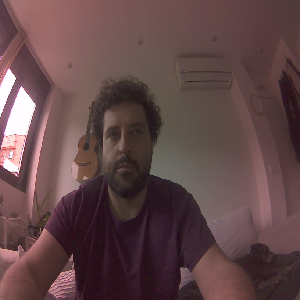

In [7]:
fr = camera.value
frame = fr.copy()
img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
img

In [8]:
camera.stop()

Pasamos el modelo de detección de caras y vemos si funciona

In [9]:

detections = mtcnn.detect(img)

print(detections)

(array([[ 96.8008  , 103.875244, 151.91724 , 185.56209 ]], dtype=float32), array([0.9996965], dtype=float32))


Sale un array con datos, por lo que entendemos que sí. Hacemos ahora el crop en el frame para ver si ha definido bien la cara

In [10]:
height = 1
width = 1
offset = 15
def detect_faces(frame,plot=False):
    detections = mtcnn.detect(frame)
    boxes,_ = detections
    if detections[0] is None:
        return []
    #draw = ImageDraw.Draw(frame)
    if not plot:
        return detections
    for bbox in boxes:
        cv2.rectangle(frame, (int(width * bbox[0]-offset), int(height * bbox[1]-offset)), (int(width * bbox[2]+offset), int(height * bbox[3]+offset)), (255, 0, 0), 2)
    return detections

In [11]:
detections =detect_faces(frame,plot=True)

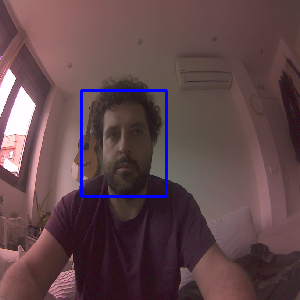

In [12]:
Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Hacemos un zoom sobre la cara

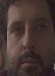

In [13]:
bbox = list(map(int,detections[0][0]))

Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).crop(bbox)

Cargamos el modelo de verificación de caras con mlflow

In [15]:
def load_model(model_uri):
    #model_uri = "/model".format(run_id)
    loaded_model = mlflow.pytorch.load_model(model_uri)
    return loaded_model

In [16]:
path_id = "../../workspace/face-verification/models/mlruns/0/2dde72cb91864989b63ff39e12122069/artifacts/model"
ss_model = mlflow.pytorch.load_model(path_id).cuda()
ss_model

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

Inicializamos el sistema de predicción que usaremos en la cámara respecto a una imagen base

In [17]:
DATA_CAMERA_DIR = "../../workspace/face-verification/data/raw/camera"
base_pic = "{0}/20210303_2315_06s_pics/manolo_c3.jpg".format(DATA_CAMERA_DIR)


In [18]:
main_pic = cv2.imread(base_pic)
detections =detect_faces(main_pic)

Cogemos solo la cara de la foto. Añadimos un obset para que salga más información

In [19]:
bbox = list(map(int,detections[0][0]))
offset = 50
width = 1.0
height = 1.0
bbox = (int(width * bbox[0]-offset), int(height * bbox[1]-offset), int(width * bbox[2]+offset), int(height * bbox[3]+offset))
bbox

(151, 51, 494, 458)

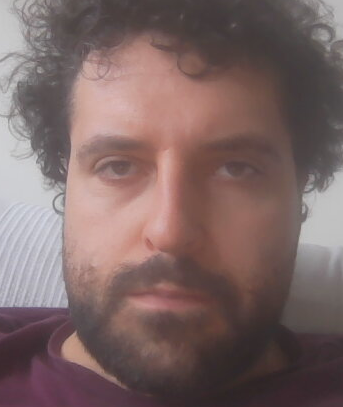

In [20]:

img = Image.fromarray(cv2.cvtColor(main_pic, cv2.COLOR_BGR2RGB)).crop(bbox)
img

la guardamos como imagen base

In [21]:
DATA_CAMERA_PROC_DIR = "../../workspace/face-verification/data/processed/base_pics"
base_pic = "{0}/base_pic_face.png".format(DATA_CAMERA_PROC_DIR)
img.save(base_pic)

Inicializamos el objeto de predicciones sobre una 

In [22]:
pred_vids = predictOverVideoSim(DATA_CAMERA_DIR,ss_model,base_pic,cuda=True)

Veamos si considera que la cara coincide

In [23]:
pred_vids.predict(frame,bbox)

0.5380663275718689

La disimilitud es baja, mostrando que las caras de las dos imágenes pertenecen a la misma persona.

**Ponemos todo esto ahora en sistema productivo**

Vemos por lo tanto que tenemos bien emplementados estos modelos. Ahora toca evaluar el de colisiones y a posteriori implementar todos en el movimiento del robot

# Control del robot para seguir a un objeto central

Queremos que el robot siga una cara, la más cercana. Para ello el proceso es el siguiente:
1. Se detectan las caras de la imagen
2. Se evalúa cual de todas ellas es la más cercana.
3. Se hace un crop del rectángulo de la cara y si es el de la persona de imagen base, se sigue a la cara. En otro caso se sigue moviendo
4. En caso de encontrarse bloqueado por un obtáculo, se gira a la izquierda.


**Empezamos por coger el modelo para evitar colisiones**

Este modelo se ha extraido  y metodología se han extraído de los notebooks de demo de jetbot

In [7]:
import torch
import torchvision
import torch.nn.functional as F
import cv2
import numpy as np

collision_model = torchvision.models.alexnet(pretrained=False)
collision_model.classifier[6] = torch.nn.Linear(collision_model.classifier[6].in_features, 2)
collision_model.load_state_dict(torch.load('../collision_avoidance/best_model.pth'))
device = torch.device('cuda')
collision_model = collision_model.to(device)

mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, stdev)

def preprocess(camera_value):
    global device, normalize
    x = camera_value
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

Cargamos el modelo de redes neuronales (antes cargado pero ya para ser introducido dentro del movimiento del robot)

In [8]:
path_id = "../../workspace/face-verification/models/mlruns/0/2dde72cb91864989b63ff39e12122069/artifacts/model"
ss_model = mlflow.pytorch.load_model(path_id).cuda()
ss_model

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [9]:
DATA_CAMERA_DIR = "../../workspace/face-verification/data/raw/camera"

DATA_CAMERA_PROC_DIR = "../../workspace/face-verification/data/processed/base_pics"
base_pic = "{0}/base_pic_face.png".format(DATA_CAMERA_PROC_DIR)

pred_vids = predictOverVideoSim(DATA_CAMERA_DIR,ss_model,base_pic,cuda=True)


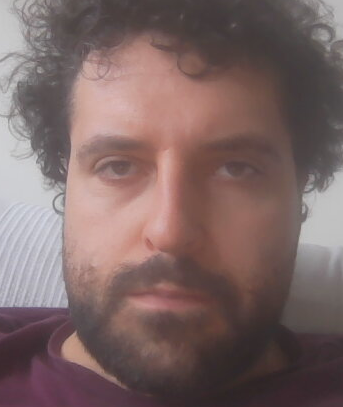

In [10]:
img = cv2.imread(base_pic)
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
#model = InceptionResnetV1(pretrained='vggface2').eval().cuda()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(keep_all=True, device=device)
detections = mtcnn.detect(img)

print(detections)

(array([[ 47.299644,  50.603638, 300.3261  , 365.96277 ]], dtype=float32), array([0.9993748], dtype=float32))


In [13]:
camera = Camera.instance(width=300, height=300)
robot = Robot()

Empezamos con el proceso de movimiento del robot en función de la situación

In [19]:
from jetbot import bgr8_to_jpeg

blocked_widget = widgets.FloatSlider(min=0.0, max=1.0, value=0.0, description='blocked')
image_widget = widgets.Image(format='jpeg', width=300, height=300)
#label_widget = widgets.FloatText(value=0, description='face disim')
speed_widget = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, description='speed')
turn_gain_widget = widgets.FloatSlider(value=0.8, min=0.0, max=2.0, description='turn gain')
detections_widget = widgets.Textarea()

display(widgets.VBox([
    widgets.HBox([image_widget, blocked_widget]),
    detections_widget,
    speed_widget,
    turn_gain_widget
]))

width = 1#int(image_widget.width)
height = 1#int(image_widget.height)
offset = 15

# threshold de bloqueo
blocked_threshold = 0.5
# threshold de dismilitud de una persona 
verif_threshold = 0.7





def detection_center(detection):
    """Computes the center x, y coordinates of the object"""
    bbox = detection
    center_x = (bbox[0] + bbox[2]) / 2.0 - 0.5
    center_y = (bbox[1] + bbox[3]) / 2.0 - 0.5
    return (center_x, center_y)
    
def norm(vec):
    """Computes the length of the 2D vector"""
    return np.sqrt(vec[0]**2 + vec[1]**2)
def closest_detection(detections):
    """Finds the detection closest to the image center"""
    closest_detection = None
    for det in detections:
        center = detection_center(det)
        if closest_detection is None:
            closest_detection = det
        elif norm(detection_center(det)) < norm(detection_center(closest_detection)):
            closest_detection = det
    return closest_detection


def execute_face_detect(change):
    image = change['new']
    image_widget.value = bgr8_to_jpeg(image)
    # execute collision model to determine if blocked
    collision_output = collision_model(preprocess(image)).detach().cpu()
    prob_blocked = float(F.softmax(collision_output.flatten(), dim=0)[0])
    blocked_widget.value = prob_blocked
    # turn left if blocked
    if prob_blocked > blocked_threshold:
        #robot.left(0.3)
        
        image_widget.value = bgr8_to_jpeg(image)
        #return
        
    # compute all detected objects
    detections = mtcnn.detect(image)
    boxes,_ = detections
    if boxes is not None:
        for bbox in boxes:
            cv2.rectangle(image, (int(width * bbox[0]), int(height * bbox[1])), (int(width * bbox[2]), int(height * bbox[3])), (255, 0, 0), 2)
        # get detection closest to center of field of view and draw it
        det = closest_detection(detections[0])
        if det is not None:
            bbox = det
            
            verif = pred_vids.predict(image,bbox)
            #label_widget.value = verif
            detections_widget.value = str(verif)
            if verif<verif_threshold:
                cv2.rectangle(image, (int(width * bbox[0]-offset), int(height * bbox[1]-offset)), (int(width * bbox[2]+offset), int(height * bbox[3]+offset)), (0, 255, 0), 5)
                image_widget.value = bgr8_to_jpeg(image)
                robot.stop()
                image_widget.value = bgr8_to_jpeg(image)
                time.sleep(2)
                robot.forward(float(speed_widget.value))
        else:
            # otherwise go forward if no target detected
            robot.forward(float(speed_widget.value))
            pass

        # otherwise steer towards target
        #else:
            # move robot forward and steer proportional target's x-distance from center
        #    center = detection_center(det)
        #    robot.set_motors(
        #        float(speed_widget.value + turn_gain_widget.value * center[0]),
        #        float(speed_widget.value - turn_gain_widget.value * center[0])
        #    )
    
    # update image widget
    image_widget.value = bgr8_to_jpeg(image)
    
execute_face_detect({'new': camera.value})

Llamamos a la siguiente funcion para que se actualice con los nuevos valores de la cámara.

In [21]:
camera.unobserve_all()
camera.observe(execute_face_detect, names='value')

Paramos el sistema

In [22]:
import time

camera.unobserve_all()
time.sleep(1.0)
robot.stop()

Again, let's close the camera conneciton properly so that we can use the camera in other notebooks.

In [ ]:
camera.stop()

# Improvement con el modelo
Hacemos una pequeña mejora en el modelo de detección para ver si mejoran los tiempos

In [23]:
#model = InceptionResnetV1(pretrained='vggface2').eval().cuda()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(device=device)
detections = mtcnn.detect(img)

print(detections)

(array([[ 47.299644,  50.603638, 300.3261  , 365.96277 ]], dtype=float32), array([0.9993748], dtype=float32))


In [31]:
from jetbot import bgr8_to_jpeg

blocked_widget = widgets.FloatSlider(min=0.0, max=1.0, value=0.0, description='blocked')
image_widget = widgets.Image(format='jpeg', width=300, height=300)
#label_widget = widgets.FloatText(value=0, description='face disim')
speed_widget = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, description='speed')
turn_gain_widget = widgets.FloatSlider(value=0.8, min=0.0, max=2.0, description='turn gain')
detections_widget = widgets.Textarea()

display(widgets.VBox([
    widgets.HBox([image_widget, blocked_widget]),
    detections_widget,
    speed_widget,
    turn_gain_widget
]))

width = 1#int(image_widget.width)
height = 1#int(image_widget.height)
offset = 15

# threshold de bloqueo
blocked_threshold = 0.9
# threshold de dismilitud de una persona 
verif_threshold = 0.7



def detect_faces(frame,plot=False):
    detections = mtcnn.detect(frame)
    boxes,_ = detections
    if detections[0] is None:
        return []
    #draw = ImageDraw.Draw(frame)
    if not plot:
        return detections
    for bbox in boxes:
        cv2.rectangle(frame, (int(width * bbox[0]-offset), int(height * bbox[1]-offset)), (int(width * bbox[2]+offset), int(height * bbox[3]+offset)), (255, 0, 0), 2)
    return detections

def execute_face_detect2(change):
    image = change['new']
    image_widget.value = bgr8_to_jpeg(image)
    # execute collision model to determine if blocked
    collision_output = collision_model(preprocess(image)).detach().cpu()
    prob_blocked = float(F.softmax(collision_output.flatten(), dim=0)[0])
    blocked_widget.value = prob_blocked
    # turn left if blocked
    if prob_blocked > blocked_threshold:
        #robot.left(0.2)
        #time.sleep(0.2)
        #robot.stop()
        #time.sleep(0.2)
        #blocked_widget.value = prob_blocked
        robot.forward(float(speed_widget.value))
        image_widget.value = bgr8_to_jpeg(image)
        return
        
    # compute all detected objects
    detections = mtcnn.detect(image)
    boxes,_ = detections
    if boxes is not None:
        bbox = boxes[0]
        verif = pred_vids.predict(image,bbox)
        detections_widget.value = str(verif)
        if verif<verif_threshold:
            cv2.rectangle(image, (int(width * bbox[0]-offset), int(height * bbox[1]-offset)), (int(width * bbox[2]+offset), int(height * bbox[3]+offset)), (0, 255, 0), 5)
            image_widget.value = bgr8_to_jpeg(image)
            robot.stop()
            print("Found!")
            time.sleep(2)
            robot.forward(float(speed_widget.value))
        else:
            center = detection_center(bbox)
            robot.set_motors(
                    float(speed_widget.value + turn_gain_widget.value * center[0]),
                    float(speed_widget.value - turn_gain_widget.value * center[0])
                )
    else:
        robot.forward(float(speed_widget.value))
    # update image widget
    image_widget.value = bgr8_to_jpeg(image)
        

execute_face_detect2({'new': camera.value})

In [32]:
camera.unobserve_all()
camera.observe(execute_face_detect2, names='value')

In [33]:
import time

camera.unobserve_all()
time.sleep(1.0)
robot.stop()